In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Loading the data


1.   Data loading function:
The Pfam_from_pickle_file_encoding function loads protein sequence data and their Pfam (protein family) domain information from pickle files. It creates a one-hot encoded feature vector for each sequence based on the presence of specific Pfam domains.

2. Loading the data:
The code loads enzyme and non-enzyme features using the function defined earlier. It then combines these features and creates corresponding labels (1 for enzymes, 0 for non-enzymes).




In [3]:
def Pfam_from_pickle_file_encoding(name_list_pickle_filename, model_names_list_filename):
    # Load the list of Pfam domain names for each protein sequence
    with open(name_list_pickle_filename, 'rb') as f:
        name_list = pickle.load(f)

    # Load the list of all possible Pfam domain names
    with open(model_names_list_filename, 'rb') as f:
        model_list = pickle.load(f)

    encoding = []
    for i, sequence_domains in enumerate(name_list):
        if i % 10000 == 0:
            print(f'Processing {i}th sequence.')

        # Create a binary vector for each sequence
        single_encoding = np.zeros(16306)

        # Set 1 for each Pfam domain present in the sequence
        for domain in sequence_domains:
            single_encoding[model_list.index(domain)] = 1

        encoding.append(single_encoding)

    return encoding

# Load enzyme and non-enzyme data
print("Loading enzyme data...")
enzyme_feature = Pfam_from_pickle_file_encoding('Pfam_name_list_new_data.pickle', 'Pfam_model_names_list.pickle')
print("Loading non-enzyme data...")
non_enzyme_feature = Pfam_from_pickle_file_encoding('Pfam_name_list_non_enzyme.pickle', 'Pfam_model_names_list.pickle')

# Combine the features and create labels
features = np.array(enzyme_feature + non_enzyme_feature)
labels = np.array([1] * len(enzyme_feature) + [0] * len(non_enzyme_feature))

Loading enzyme data...
Processing 0th sequence.
Processing 10000th sequence.
Processing 20000th sequence.
Loading non-enzyme data...
Processing 0th sequence.
Processing 10000th sequence.
Processing 20000th sequence.


In [4]:
# Convert to PyTorch tensors
X = torch.FloatTensor(features)
y = torch.LongTensor(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Defining the neural network

Building the network:
A Sequential model is created using Keras. The architecture consists of:


An input layer with 16,306 features
Two hidden layers with 1024 neurons each, using ReLU activation
Dropout layers (30% dropout rate) after each hidden layer to prevent overfitting
An output layer with 2 neurons (for binary classification) using softmax activation

In [5]:
# Define the neural network
class EnzymeNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EnzymeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Training the model

In [9]:
# Initialize the model
model = EnzymeNet(input_size=16306, hidden_size=1024, num_classes=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0

# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break



Epoch [1/20], Train Loss: 0.2870, Train Acc: 89.56%, Val Loss: 0.9314, Val Acc: 50.45%
Epoch [2/20], Train Loss: 0.1236, Train Acc: 95.93%, Val Loss: 0.1801, Val Acc: 93.73%
Epoch [3/20], Train Loss: 0.1033, Train Acc: 96.60%, Val Loss: 0.1783, Val Acc: 94.29%
Epoch [4/20], Train Loss: 0.0953, Train Acc: 96.76%, Val Loss: 0.1828, Val Acc: 94.41%
Epoch [5/20], Train Loss: 0.0902, Train Acc: 96.92%, Val Loss: 0.1938, Val Acc: 94.38%
Epoch [6/20], Train Loss: 0.0877, Train Acc: 97.06%, Val Loss: 0.1901, Val Acc: 94.23%
Epoch [7/20], Train Loss: 0.0835, Train Acc: 97.16%, Val Loss: 0.1935, Val Acc: 94.32%
Epoch [8/20], Train Loss: 0.0801, Train Acc: 97.22%, Val Loss: 0.2082, Val Acc: 94.05%
Early stopping


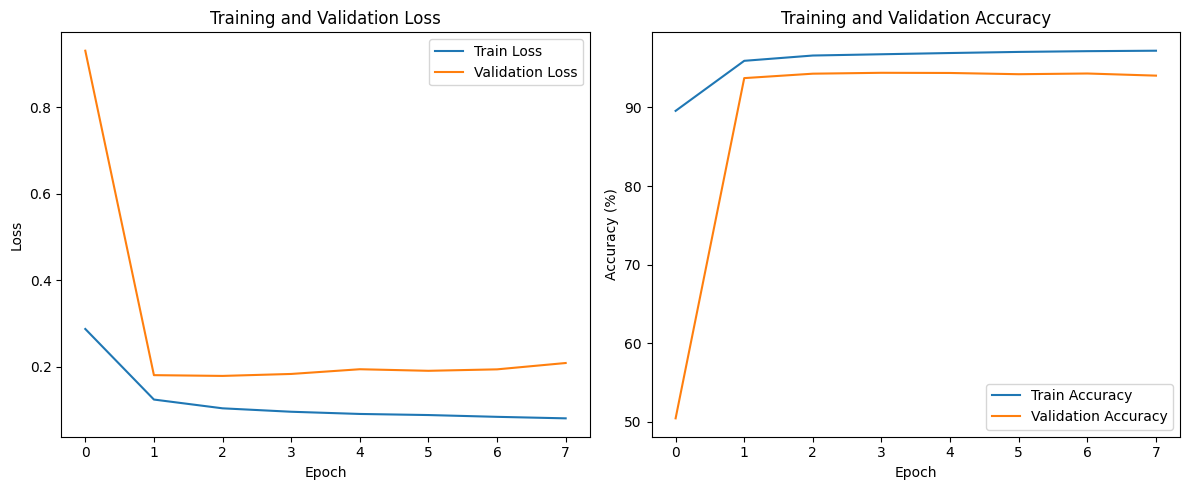

Test Loss: 0.1783, Test Accuracy: 94.29%


In [10]:
# Visualizations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')